# A Super-Simple Neural Network Demo

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (4,4)

### Create some 2-dimensional data

In [2]:
def ground_truth(x,y):
    return (1.3*x-.5)*(1.3*x-.5) + (y-.5)*(y-.5) < .05

def createSamples(N, xl, xr, yu, yo, ground_truth):
    """
        ground_truth is a function that calculates the "true" label, given coordinates x and y
        Produce N samples in the rectangle [xl, xr, yu, yo] with the given ground_truth
    """
    np.random.seed(1234)
    x = np.random.uniform(xl,xr,N)
    y = np.random.uniform(yu,yo,N)
    c = ground_truth(x, y) * 1.0
    return x, y, c

In [3]:
# Before rerunning, close the previous session. Ignore error the very first time
try: 
    sess.close()
except NameError:
    print("Don't worry. Need to ignore this error once")
sess = tf.InteractiveSession()
FLAGS=lambda: None

Don't worry. Need to ignore this error once


## The 2-dimensional input data, classes are represented by colors

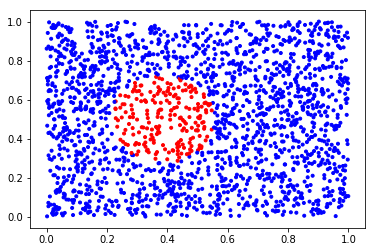

In [4]:
N=2000
sx, sy, sc = createSamples(N, 0, 1, 0, 1, ground_truth)
points=np.array([sx, sy])
tr_samples = points.T # Need transposed for use with Tensorflow
plt.scatter(sx, sy, c=sc, cmap="bwr", marker='.')

### The Neural Network
We'll be creating a simple feed-forward network with two hidden layers.

![NN](images/NN_2x3x3x2_small.png)

Our neural network will be defined as

$ f(x) = \Theta^{(3)} \cdot \sigma(\Theta^{(2)} \cdot \sigma(\Theta^{(1)} \cdot x + b^{(1)} ) + b^{(2)}) + b^{(3)}$

Note, that we omit the final non-linearity at this point. That's for mere technical reasons and doesn't change the story.

Below you see the neural network in code, featuring some illustrative initial values.

You see: We have 2 input nodes, 3 nodes in each of the hidden layers and again 2 nodes in the output layer

### Weight matrices and biases initialized to some values

In [5]:
Theta1 = np.array([[1.6, 4], [1.6, -1.2], [-3.6, 1.6]])              # 3x2 weight Matrix towards the first hidden layer
b1 = np.array([[-1, 1, 6]]).T                                        # bias of the first hidden layer
Theta2 = np.array([[1, 2, -3], [.5, .2, -3], [2, 1, -.2]])           # 3x3 weight Matrix towards the second hidden layer
b2 = np.array([[.2, .1, -.4]]).T                                     # bias of the 2nd hidden layer
Theta3 = np.array([[.5, 2, -.03], [.2, 1, -.2]])                     # 2x3 weight Matrix towards the output layer
b3 = np.array([[.2, .3]]).T                                          # bias of the output layer

In [6]:
#
# NOTE: You need to initialize with the transpose of the weight matrix, otherwise TF mixes up columns and rows
#       Of course that's not a problem, since typically, all numbers are randomly initialized, anyway.
# (can you imagine the frustration until I found out?)
#
W1_i=tf.constant_initializer(Theta1.T)
b1_i=tf.constant_initializer(b1)
W2_i=tf.constant_initializer(Theta2.T)
b2_i=tf.constant_initializer(b2)
W3_i=tf.constant_initializer(Theta3.T)
b3_i=tf.constant_initializer(b3)

def feed_forward(x):
    _dense1=tf.layers.Dense(3, activation=tf.nn.sigmoid, kernel_initializer=W1_i, bias_initializer=b1_i)
    _dense2=tf.layers.Dense(3, activation=tf.nn.sigmoid, kernel_initializer=W2_i, bias_initializer=b2_i)
    _logits=tf.layers.Dense(2, kernel_initializer=W3_i, bias_initializer=b3_i)    

    y = _dense1(x)
    y = _dense2(y)
    y = _logits(y)
    return y

### Placeholder for the different data sets

In [7]:
X = tf.placeholder(dtype=tf.float64, shape=[None, 2])
L = tf.placeholder(dtype=tf.int64, shape=[None])

In [8]:
classes = tf.one_hot(L, depth=2)
output = feed_forward(X)
probs = tf.nn.softmax(output)
objective = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=classes))

In [9]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
train = optimizer.minimize(objective)
preds = tf.argmax(probs,axis=1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, L), dtype=tf.float64))

In [10]:
N_test=20
tsx, tsy, tlabels = createSamples(N_test, 0, 1, 0, 1, ground_truth)
tsamples=np.array([tsx, tsy])
test_data = tf.transpose(tsamples)
ds_test = tf.data.Dataset.from_tensor_slices(test_data)
tensor_test = ds_test.batch(20).make_one_shot_iterator().get_next()
toutput = feed_forward(tensor_test)
tprobs = tf.nn.softmax(toutput)
inferenced = tf.argmax(tprobs,axis=1)

In [11]:
init = tf.global_variables_initializer()
sess.run(init)
losses = []
accies = []
n_batch = 50

def single_batch(n_batch):
    for _ in range(n_batch):
        _, _all_output, _objective, _accuracy = sess.run([train, output, objective, accuracy], feed_dict={X: tr_samples, L: sc.astype(int)})

    print ("Loss: %s - Accuracy: %s" % (_objective, _accuracy))
    losses.append(_objective)
    accies.append(_accuracy)
    return _all_output

for _ in range (50): 
    all_output = single_batch(n_batch)


Loss: 0.3420688125894798 - Accuracy: 0.8925
Loss: 0.33544783665975064 - Accuracy: 0.8925
Loss: 0.32491067657518513 - Accuracy: 0.8925
Loss: 0.31836930294231036 - Accuracy: 0.8925
Loss: 0.31238938001426475 - Accuracy: 0.8925
Loss: 0.30764555690039896 - Accuracy: 0.8925
Loss: 0.3039233583608092 - Accuracy: 0.8925
Loss: 0.3008826686442919 - Accuracy: 0.8925
Loss: 0.2983351617147745 - Accuracy: 0.8925
Loss: 0.2961653145084073 - Accuracy: 0.8925
Loss: 0.2942918129510555 - Accuracy: 0.8925
Loss: 0.29265407309167263 - Accuracy: 0.8925
Loss: 0.2912060160559664 - Accuracy: 0.8925
Loss: 0.2899122017956191 - Accuracy: 0.8925
Loss: 0.28874507507374797 - Accuracy: 0.8925
Loss: 0.2876828509236639 - Accuracy: 0.8925
Loss: 0.28670769826247455 - Accuracy: 0.8925
Loss: 0.28580377122728107 - Accuracy: 0.8925
Loss: 0.28495397307897913 - Accuracy: 0.8925
Loss: 0.28413115353055524 - Accuracy: 0.8925
Loss: 0.2832594438261566 - Accuracy: 0.8925
Loss: 0.2819294295648565 - Accuracy: 0.8925
Loss: 0.2777396823220

### After some period of stagnation the network learned to predict the colors from the coordinates

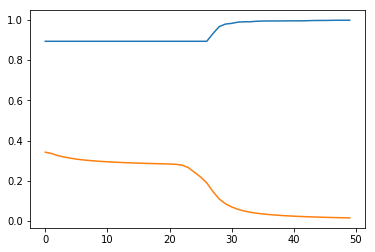

In [12]:
plt.plot(accies)
plt.plot(losses)

### Inferring the classes (colors) of some given test coordinates

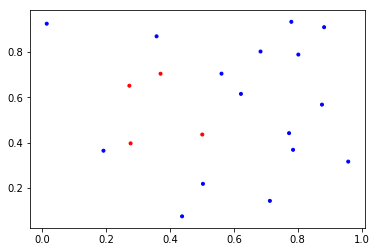

In [13]:
N=20
sx, sy, sc = createSamples(N, 0, 1, 0, 1, ground_truth)
points=np.array([sx, sy])
plt.scatter(sx, sy, c=sc, cmap="bwr", marker='.')

test_samples = np.array([sx, sy]).T
test_labels = sc.astype(int)

### The network correctly infers the classes of the given test coordinates

In [14]:
test_inferred = sess.run(preds, feed_dict={X: test_samples, L: test_labels})

print("true classes   : %s" % test_labels)
print('infered classes: %s' % test_inferred)

true classes   : [0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0]
infered classes: [0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0]
